In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load engineered features
df = pd.read_csv("../data/nifty_model_features.csv")

df.head()


,Datetime,Close,High,Low,Open,Volume,EMA_5,EMA_15,Returns
0,2025-10-24 03:50:00+00:00,25886.000000,25892.400391,25840.400391,25851.150391,0.0,25862.533854,25855.200684,0.001362
1,2025-10-24 03:55:00+00:00,25886.400391,25893.300781,25859.500000,25886.300781,0.0,25870.489366,25859.100647,0.000015
2,2025-10-24 04:00:00+00:00,25875.400391,25887.599609,25864.500000,25885.849609,0.0,25872.126374,25861.138115,-0.000425
3,2025-10-24 04:05:00+00:00,25914.300781,25914.699219,25862.550781,25876.150391,0.0,25886.184510,25867.783448,0.001503
4,2025-10-24 04:10:00+00:00,25903.500000,25913.300781,25883.449219,25913.199219,0.0,25891.956340,25872.248017,-0.000417


ML target variable

In [2]:
df["Future_Return"] = df["Returns"].shift(-1)
df["Target"] = (df["Future_Return"] > 0).astype(int)

df = df.dropna().reset_index(drop=True)

df["Target"].value_counts()


Target
1    2150
0    2100
Name: count, dtype: int64

In [3]:
features = ["EMA_5", "EMA_15", "Returns"]

X = df[features]
y = df["Target"]

split = int(0.7 * len(df))

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

X_train.shape, X_test.shape


((2975, 3), (1275, 3))

ML model train

In [4]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

ML model evaluation

In [5]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.49333333333333335
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       654
           1       0.48      0.53      0.50       621

    accuracy                           0.49      1275
   macro avg       0.49      0.49      0.49      1275
weighted avg       0.49      0.49      0.49      1275



In [6]:
df["Signal"] = 0
df.loc[df["EMA_5"] > df["EMA_15"], "Signal"] = 1
df.loc[df["EMA_5"] < df["EMA_15"], "Signal"] = -1

df["Strategy_Return"] = df["Signal"].shift(1) * df["Returns"]
df["Cumulative_Return"] = (1 + df["Strategy_Return"]).cumprod()


ML as trade filter

In [7]:
df["ML_Pred"] = model.predict(df[features])

df["ML_Signal"] = 0

df.loc[
    (df["EMA_5"] > df["EMA_15"]) & (df["ML_Pred"] == 1),
    "ML_Signal"
] = 1

df.loc[
    (df["EMA_5"] < df["EMA_15"]) & (df["ML_Pred"] == 1),
    "ML_Signal"
] = -1

df["ML_Return"] = df["ML_Signal"].shift(1) * df["Returns"]
df["ML_Cumulative"] = (1 + df["ML_Return"]).cumprod()


baseline vs ML strategy

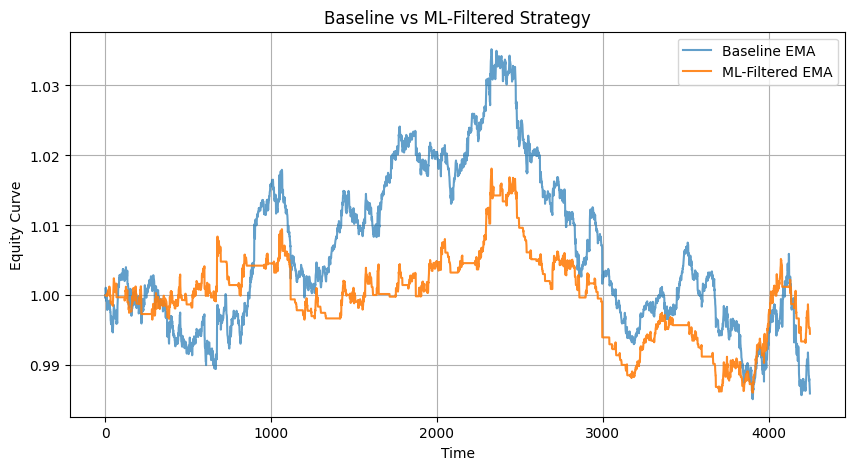

In [8]:
os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(df["Cumulative_Return"], label="Baseline EMA", alpha=0.7)
plt.plot(df["ML_Cumulative"], label="ML-Filtered EMA", alpha=0.9)

plt.xlabel("Time")
plt.ylabel("Equity Curve")
plt.title("Baseline vs ML-Filtered Strategy")
plt.legend()
plt.grid(True)

plt.savefig("../plots/baseline_vs_ml_equity.png", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
df.to_csv("../data/ml_strategy_results.csv", index=False)

print("ML trade filtering completed successfully")


ML trade filtering completed successfully


In [10]:
import joblib
joblib.dump(model, "../models/logistic_regression.pkl")


['../models/logistic_regression.pkl']